# Comparative Analysis
In this notebook, we compare NEWMA with different parameter settings.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np

import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys

sys.path.append("../../")

Let's choose a score for evaluation (F1 or Covering).

In [3]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [4]:
thresholds = (0.95, 0.96, 0.97, 0.98, 0.99, 1.)
methods = list()

for t in thresholds:
    candidate_name = f"{t}-threshold"
    methods.append((candidate_name, f"{candidate_name}.csv"))

for idx, (name, file_name) in enumerate(methods):
    methods[idx] = name, pd.read_csv(f"../../experiments/newma_thresholding_quantile/{file_name}")

df_scores = pd.DataFrame()

for name, df in methods:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores

,dataset,0.95-threshold,0.96-threshold,0.97-threshold,0.98-threshold,0.99-threshold,1.0-threshold
0,DodgerLoopDay,0.057,0.057,0.058,0.078,0.118,1.000
1,EEGRat,0.095,0.104,0.124,0.157,0.209,0.500
2,EEGRat2,0.078,0.086,0.086,0.086,0.110,0.500
3,FaceFour,0.097,0.097,0.111,0.118,0.149,0.281
4,GrandMalSeizures2,0.035,0.035,0.035,0.035,0.039,0.508
5,GreatBarbet1,0.063,0.075,0.095,0.126,0.148,0.355
6,Herring,0.045,0.051,0.154,0.718,1.000,1.000
7,InlineSkate,0.091,0.091,0.115,0.149,0.228,0.358
8,InsectEPG1,0.018,0.019,0.022,0.022,0.034,0.653
9,MelbournePedestrian,0.119,0.173,0.341,0.394,0.440,0.149


Let's calculate the mean/std score.

In [5]:
df_scores.mean(axis=0).round(3)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4223/3088260556.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.mean(axis=0).round(3)


0.95-threshold    0.065
0.96-threshold    0.073
0.97-threshold    0.092
0.98-threshold    0.136
0.99-threshold    0.193
1.0-threshold     0.462
dtype: float64

In [6]:
df_scores.std(axis=0).round(3)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4223/2527189798.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.std(axis=0).round(3)


0.95-threshold    0.032
0.96-threshold    0.040
0.97-threshold    0.070
0.98-threshold    0.157
0.99-threshold    0.218
1.0-threshold     0.241
dtype: float64

Let's compute the wins per method.

In [7]:
ranks = df_scores.rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))

In [8]:
for mean, name in zip(means, df_scores.columns[1:]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 5)}")

0.95-threshold:wins=0 rank=4.95238
0.96-threshold:wins=0 rank=4.28571
0.97-threshold:wins=0 rank=3.57143
0.98-threshold:wins=0 rank=2.85714
0.99-threshold:wins=5 rank=1.80952
1.0-threshold:wins=17 rank=1.33333


Let's plot and output the ranks.

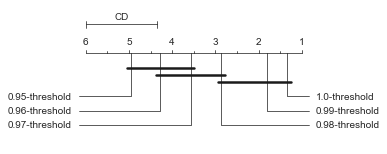

In [9]:
cd = Orange.evaluation.scoring.compute_CD(means, df_scores.shape[0])
Orange.evaluation.scoring.graph_ranks(means, df_scores.columns[1:], cd=cd, reverse=True, width=5,
                                      filename="../../figures/cd_ablation_newma_thresholding_quantile.pdf")

Let's compute pairwise wins/losses.

In [10]:
selection = "1.0-threshold"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

1.0-threshold vs 0.95-threshold: (wins/ties/losses): 21/0/0
1.0-threshold vs 0.96-threshold: (wins/ties/losses): 20/0/1
1.0-threshold vs 0.97-threshold: (wins/ties/losses): 20/0/1
1.0-threshold vs 0.98-threshold: (wins/ties/losses): 20/0/1
1.0-threshold vs 0.99-threshold: (wins/ties/losses): 16/1/4


/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4223/3922786506.py:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_4223/3922786506.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


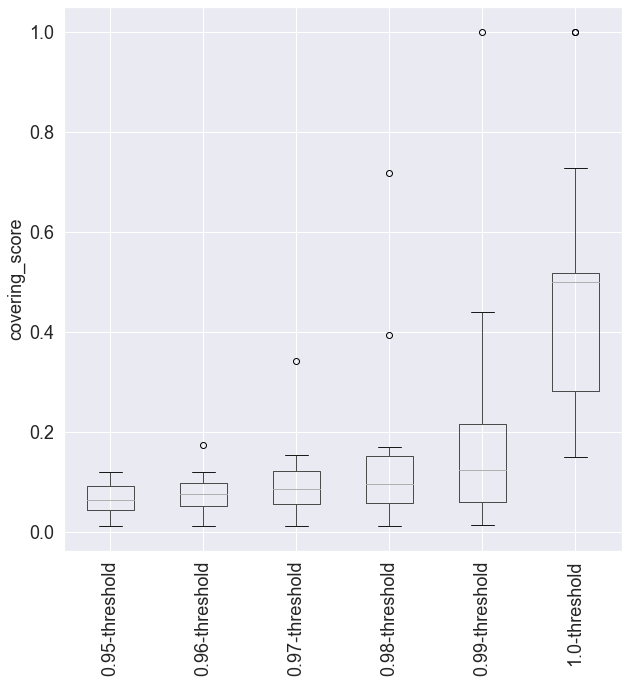

In [11]:
fontsize = 18
_, ax = plt.subplots(figsize=(10, 10))

df_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel(eval_score, fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig("../../figures/bp_ablation_newma_thresholding_quantile.pdf", bbox_inches="tight") 